In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, assemble, transpile
from qiskit import BasicAer, execute, assemble,IBMQ
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector,plot_bloch_vector,plot_histogram, plot_state_qsphere, array_to_latex
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from math import sqrt, pi
import numpy as np

C:\Users\askev\AppData\Local\Temp\ipykernel_560\2568981542.py:9: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import marginal_counts


Deutsch-Jozsa Algorithm

In [2]:
n=3
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

dj_circuit = QuantumCircuit(n+1, n)
# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

C:\Users\askev\AppData\Local\Temp\ipykernel_560\1267209358.py:37: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


┌───┐┌───┐ ░                 ░ ┌───┐┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├┤ H ├─░─┤M├──────
     ├───┤└───┘ ░   │             ░ ├───┤└───┘ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├──────░──╫─┤M├───
     ├───┤┌───┐ ░   │    │        ░ ├───┤┌───┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘└───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░────────────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░            ░  ║  ║  ║ 
c: 3/═════════════════════════════════════════════╩══╩══╩═
                                                  0  1  2

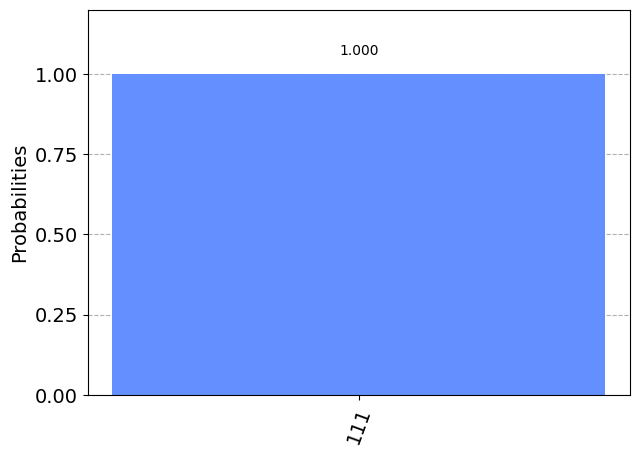

In [3]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [4]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

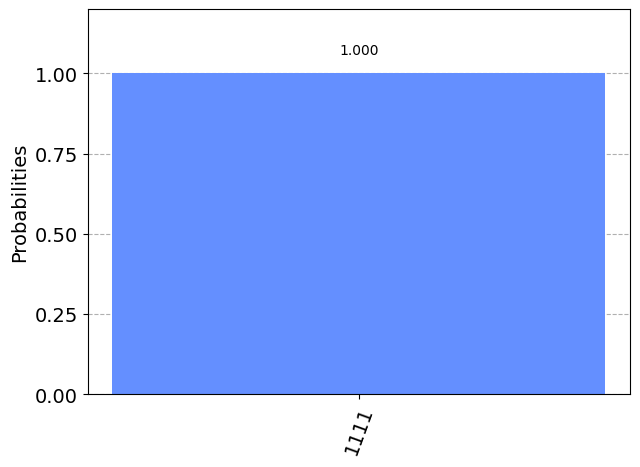

In [5]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

least busy backend:  ibmq_belem
Job Status: job has successfully run


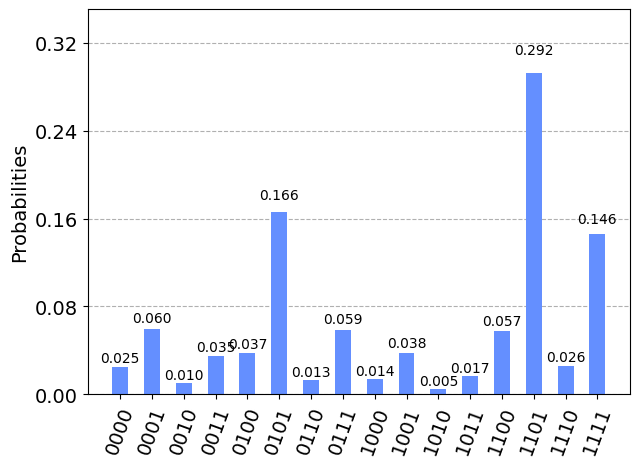

In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.enable_account('99e1dd08f2c46188b04a339f1db939ca95b546d2f5ce04176d8a47effe5a12c21cf224a58afb38ee95effeeba182ac34cd14fc18f276cd5ef7948e910f68eea5')
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Quantum Teleportation

In [9]:
#%%
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'    

#IBMQ.enable_account('99e1dd08f2c46188b04a339f1db939ca95b546d2f5ce04176d8a47effe5a12c21cf224a58afb38ee95effeeba182ac34cd14fc18f276cd5ef7948e910f68eea5')
provider = IBMQ.get_provider(hub='ibm-q')

## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

init_gate = Initialize(psi)
init_gate.label = "init"

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

svsim = Aer.get_backend('aer_simulator')
qc.save_statevector()
# qc.measure_all()
# qc.save_unitary()
qobj = assemble(qc)
result = svsim.run(qobj).result()
final_state = result.get_statevector()
final_state = Statevector(final_state)

display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)
plot_state_qsphere(final_state)

qc.draw()
print(qc)
plt.show()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

       ┌───────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(0.26054+0.85977j,-0.43838-0.027206j) ├─░────────────░───■──┤ H ├»
       └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                     ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ──────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                     ░      └───┘ ░           »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░ ┌─┐                  ░ 
«  q_0: ─░─┤M├──────────────────░─
«        ░ └╥┘┌─┐               ░ 
«  q_1: ─░──╫─┤

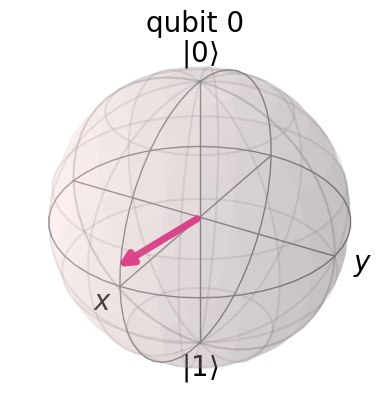

In [ ]:
plot_bloch_multivector(psi)

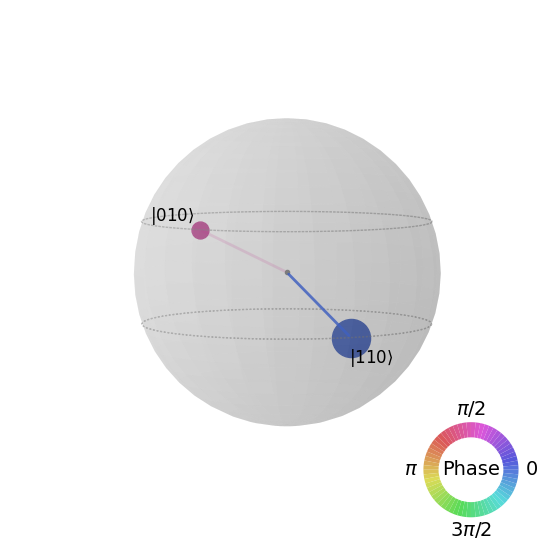

In [ ]:
plot_state_qsphere(final_state)

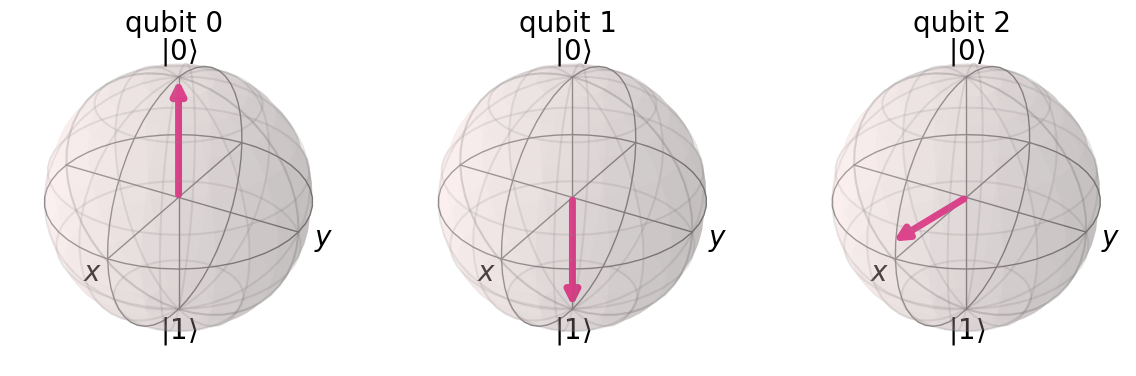

In [ ]:
plot_bloch_multivector(final_state)